<a href="https://colab.research.google.com/github/H12-25-L-Equipo-36/Hackaton-Flightdelay/blob/Data_science/catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

In [ ]:
gdown.download("https://drive.google.com/uc?id=1_8Uzy9vxZr8Vl1328jWufiw4NsK_XxjN","datafinal.csv", quiet=False)
df= pd.read_csv("datafinal.csv")


Downloading...
From (original): https://drive.google.com/uc?id=1_8Uzy9vxZr8Vl1328jWufiw4NsK_XxjN
From (redirected): https://drive.google.com/uc?id=1_8Uzy9vxZr8Vl1328jWufiw4NsK_XxjN&confirm=t&uuid=ac7bfebb-ecf1-40c1-9ece-009b2bd040f8
To: /content/datafinal.csv
100%|██████████| 247M/247M [00:02<00:00, 87.9MB/s]


# 🤖 Machine Learning inicio de Modelado

In [ ]:
features = [
    "airline",
    "origin",
    "destination",
    "distance_km",
    "day_of_week",
    "hour"
]
x = df[features]
y = df["delays"]


In [ ]:
categorical_features=["airline", "origin", "destination"]
numbers_features=["distance_km", "day_of_week", "hour"]

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split



In [ ]:
x_train, x_test, y_train, y_test= train_test_split(
    x, y, test_size=0.2, random_state=785, stratify=y
)


In [ ]:
one_hot= ColumnTransformer(
   transformers=[("cat", OneHotEncoder(handle_unknown= "ignore"), categorical_features),
                 ("num","passthrough",numbers_features)
])


In [ ]:
y = y.astype(int)


In [ ]:

model_cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    class_weights=[1, 3],
    eval_metric="AUC",
    random_state=42,
    verbose=100
)

In [ ]:
model_cat.fit(
    x_train_small,
    y_train_small,
    cat_features=categorical_features,
    eval_set=(x_test, y_test),
    early_stopping_rounds=50
)


0:	test: 0.6571714	best: 0.6571714 (0)	total: 4.81s	remaining: 1h 20m 3s
100:	test: 0.6950229	best: 0.6950229 (100)	total: 6m 52s	remaining: 1h 1m 9s
200:	test: 0.7026039	best: 0.7026039 (200)	total: 13m 43s	remaining: 54m 31s
300:	test: 0.7072768	best: 0.7072768 (300)	total: 20m 38s	remaining: 47m 55s
400:	test: 0.7114258	best: 0.7114258 (400)	total: 27m 47s	remaining: 41m 30s
500:	test: 0.7145404	best: 0.7145404 (500)	total: 34m 50s	remaining: 34m 41s
600:	test: 0.7175527	best: 0.7175527 (600)	total: 41m 52s	remaining: 27m 47s
700:	test: 0.7198448	best: 0.7198448 (700)	total: 48m 50s	remaining: 20m 49s
800:	test: 0.7223592	best: 0.7223592 (800)	total: 56m 27s	remaining: 14m 1s
900:	test: 0.7239338	best: 0.7239338 (900)	total: 1h 4m 10s	remaining: 7m 3s
999:	test: 0.7255995	best: 0.7255995 (999)	total: 1h 11m 14s	remaining: 0us

bestTest = 0.7255994771
bestIteration = 999



In [ ]:
y_pred = model_cat.predict(x_test)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import numpy as np
def val_cross_catboost(model, X, y, cat_features):
    y = y.astype(int)
    cat_features_idx = [X.columns.get_loc(c) for c in cat_features]

    skf = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=785
    )

    metrics = {
        "precision": [],
        "recall": [],
        "accuracy": [],
        "f1": []
    }

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(
            X_train,
            y_train,
            cat_features=cat_features_idx,
            verbose=0
        )

        y_pred = model.predict(X_val)
        y_pred = np.array(y_pred).astype(int)

        metrics["precision"].append(precision_score(y_val, y_pred))
        metrics["recall"].append(recall_score(y_val, y_pred))
        metrics["accuracy"].append(accuracy_score(y_val, y_pred))
        metrics["f1"].append(f1_score(y_val, y_pred))

    return metrics


In [ ]:
val_cross_catboost(model_cat, x_train_small, y_train_small, categorical_features)

{'precision': [0.4524256816928883, 0.45315450992729234, 0.4531795052155],
 'recall': [0.9007526922573591, 0.8999569407682273, 0.9002399913881718],
 'accuracy': [0.5436675423281366, 0.5449591699895374, 0.5449777953413946],
 'f1': [0.6023206676612519, 0.6027878135830805, 0.6028734104928674]}

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


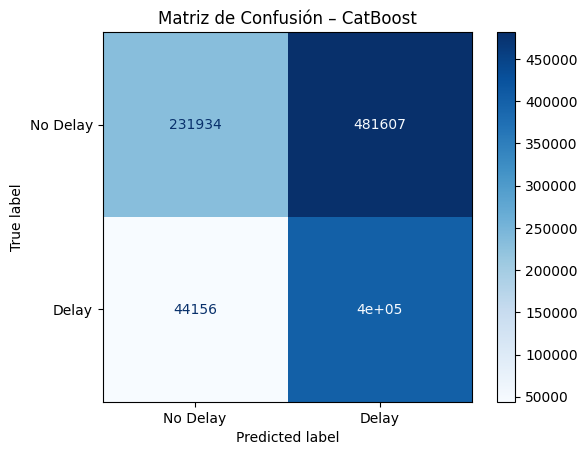

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Delay", "Delay"]
)

disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – CatBoost")
plt.show()


In [ ]:
y_proba = model_cat.predict_proba(x_test)[:, 1]


In [ ]:
y_pred = model_cat.predict(x_test)


In [ ]:
pd.DataFrame({
    "y_real": y_test[:10],
    "y_pred": y_pred[:10],
    "y_proba": y_proba[:10]
})


,y_real,y_pred,y_proba
3303368,1,1,0.957461
1083267,1,1,0.902903
3987086,0,0,0.378124
4883091,0,1,0.565640
2643009,0,1,0.744358
4251546,1,1,0.710952
4240650,0,1,0.690442
4500272,0,0,0.341735
1025391,1,1,0.611628
2971317,0,1,0.622743


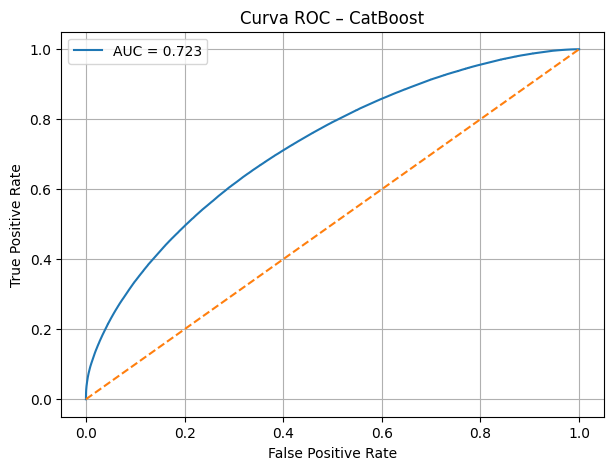

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – CatBoost")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
for i, vuelo in enumerate([vuelo_pb1,vuelo_pb2], start=1):
  prob= model_cat.predict_proba(vuelo)[0,1]
  pred= int(prob >=0.4)
  print(f"Vuelo {i}: ")
  print(f"  La probabilidad de delay es: {prob: .2f}")
  print (f" Prediccion final: {'Delay' if pred else 'No Delay'}\n")

Vuelo 1: 
  La probabilidad de delay es:  0.53
 Prediccion final: Delay

Vuelo 2: 
  La probabilidad de delay es:  0.63
 Prediccion final: Delay



In [ ]:
model_cat.is_fitted()


True

In [ ]:
model_cat.get_params()

{'iterations': 1000,
 'learning_rate': 0.05,
 'depth': 6,
 'loss_function': 'Logloss',
 'verbose': 100,
 'class_weights': [1, 3],
 'eval_metric': 'AUC',
 'random_state': 42}

In [ ]:
model_cat.save_model("catboost_model.cbm")
